# Analysing Herald Articles

In [1]:
OVERWRITE = True

Here I'll be analysing over 300,000 articles from the NZ Herald.

In [2]:
# The usual suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# For this analysis
import os
import re
import json
import jellyfish

The articles are recorded as json. Here is one example:

In [3]:
! head -n 1 ../news/nzherald.json

{"headline": [" Live: Christchurch mosque shootings - NZ in mourning as 49 people killed and more than 40 injured in terror attack ", " "], "date": "16 Mar, 2019 9:15am", "url": "https://www.nzherald.co.nz/nz/news/article.cfm?c_id=1&objectid=12213236", "syndicator_name": ["NZ Herald"], "byline": null, "paragraphs": [" KEY POINTS:\n• 36 mins of terror: Police confirm sole gunman responsible for both mosque shootings\n• PM Ardern says gunman \"absolutely\" intended to continue his attack\n• Australian-born Dunedin resident Brenton Harrison Tarrant appeared in court today \n• 49 are confirmed dead, victims range from 2 to older than 60\n• 12 people remain in critical care as survivors' harrowing tales emerge\n• Attorney General says semi-automatic weapons will be banned \n• Kiwis have already donated more than $2.5m", " New Zealand is in mourning after the deadly massacre at two Christchurch mosques. Join us for live updates as the country comes to grips with the tragedy."]}


In [4]:
! head ../news/nzherald.json > ../data/nzherald_sample.json

In [5]:
%%time
herald_data = pd.read_json("../news/nzherald.json", lines = True)
herald_data.head()

CPU times: user 36.2 s, sys: 1.89 s, total: 38 s
Wall time: 38 s


In [6]:
print("herald_data has {} rows".format(len(herald_data)))

herald_data has 306696 rows


## Clean columns

In [7]:
def delist_entry(x):
    '''
    Extracts and cleans text in a list
    '''
    if isinstance(x, list):
        x = ' '.join(x).strip()
        return x
    elif x is None:
        return ''
    else:
        raise ValueError("Type is not list or None: {}".format(x))

In [8]:
for col in ['byline', 'headline', 'syndicator_name']:
    herald_data[col] = herald_data[col].apply(delist_entry).str.replace('\s{2,}', ' ', regex = True)

# Fix bylines
herald_data['byline'] = (herald_data.byline
    .str.replace('^By:? ', '', regex = True))
    
# Create articles column
herald_data['article'] = (herald_data['paragraphs']
    .apply(lambda x: '\n'.join(x))
    .str.strip())

In [9]:
herald_data.head()

,byline,date,headline,paragraphs,syndicator_name,url,article
0,,2019-03-16 09:15:00,Live: Christchurch mosque shootings - NZ in mo...,[ KEY POINTS:\n• 36 mins of terror: Police con...,NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,KEY POINTS:\n• 36 mins of terror: Police confi...
1,Craig Timberg,2019-03-15 14:07:00,"Sex, drugs and Peppa Pig: Why you can't trust ...",[ The YouTube video starts with a popular Brit...,Washington Post,https://www.nzherald.co.nz/business/news/artic...,The YouTube video starts with a popular Britis...
2,"Andrea Fox Business Reporter, NZ Herald andrea...",2019-03-15 17:50:00,Fonterra jobs go in shakeup but details under ...,[ Jobs have been lost at Fonterra but New Zeal...,,https://www.nzherald.co.nz/business/news/artic...,Jobs have been lost at Fonterra but New Zealan...
3,Chris Schulz,2019-03-16 08:32:00,Sol3 Mio on turning their back on fame,"[ Glasses clink, knives and forks rattle, and ...",Canvas,https://www.nzherald.co.nz/entertainment/news/...,"Glasses clink, knives and forks rattle, and yo..."
4,,2019-03-15 12:41:00,"Continuous Disclosure: Big-money Goodman deal,...",[ Continuous Disclosure is a market news colum...,NZ Herald,https://www.nzherald.co.nz/business/news/artic...,"Continuous Disclosure is a market news column,..."


### Herald Quiz

There are a number of Herald quiz articles in the `herald_data`. We remove those here.

In [10]:
quiz_rows = herald_data.headline.str.match('Herald [A-z]+ quiz:')
print("Found {} herald quizzes in herald_data".format(np.sum(quiz_rows)))
herald_data[quiz_rows].head()

Found 260 herald quizzes in herald_data


,byline,date,headline,paragraphs,syndicator_name,url,article
2871,,2017-07-13 05:30:00,Herald daily quiz: July 13,[ • App users try the quiz here.\n],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,• App users try the quiz here.
2902,,2017-07-12 05:30:00,Herald daily quiz: July 12,[ • App users try the quiz here.\n],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,• App users try the quiz here.
2904,,2017-07-07 05:30:00,Herald daily quiz: July 7,[ • App users try the quiz here.\n],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,• App users try the quiz here.
2906,,2017-07-11 05:30:00,Herald daily quiz: July 11,[ • App users try the quiz here.\n],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,• App users try the quiz here.
2935,,2017-04-11 05:30:00,Herald daily quiz: April 11,[],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,


In [11]:
# Remove daily quiz articles
herald_data = herald_data[~herald_data.headline.str.match('Herald [A-z]+ quiz:')]

Another issue is Cartoon articles, which contain no article text.

In [12]:
cartoon_rows = herald_data.headline.str.match('Cartoon:')
print("Found {} herald quizzes in herald_data".format(np.sum(cartoon_rows)))
herald_data[cartoon_rows].head()

Found 554 herald quizzes in herald_data


,byline,date,headline,paragraphs,syndicator_name,url,article
2395,,2016-11-05 05:00:00,Cartoon: Auckland ratepayers v Duco,[ None],NZ Herald,https://www.nzherald.co.nz/sport/news/article....,None
3632,,2014-06-19 05:46:00,Cartoon: Disastrous brain-fade club,[ None],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,None
3663,,2016-08-07 05:00:00,Cartoon: The Rio Olympics debt,[ None],Herald on Sunday,https://www.nzherald.co.nz/sport/news/article....,None
4806,,2012-07-19 05:29:00,Cartoon: Olympics security is but a spoonful o...,[ None],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,None
4812,,2012-07-18 05:29:00,"Cartoon: Bring your tools, John",[ None],NZ Herald,https://www.nzherald.co.nz/opinion/news/articl...,None


In [13]:
# Remove cartoon articles
herald_data = herald_data[~herald_data.headline.str.match('Cartoon:')]

Another issue: Paragraphs containing `None` as values, gives rise to articles containing just `'None'`. We can remove those now too.

In [14]:
herald_data.loc[herald_data.article.str.strip() == 'None', 'paragraphs'].apply(str).value_counts()

[' None']         151
[' ', ' None']     10
Name: paragraphs, dtype: int64

In [15]:
herald_data = herald_data[herald_data.article != 'None']

Now we remove articles with empty contents.

In [16]:
herald_data = herald_data[herald_data.article.str.len() != 0]

In [17]:
herald_data[herald_data.article.str.len() < 100].sample(10)

,byline,date,headline,paragraphs,syndicator_name,url,article
19552,,2014-01-09 14:00:00,Cycling blackspots: Where needs improvement?,[ Cycling blackspots: Where needs improvement?],Herald online,https://www.nzherald.co.nz/nz/news/article.cfm...,Cycling blackspots: Where needs improvement?
226435,,2013-11-08 04:56:00,Twitter stock opens at $45.10 on the New York ...,[ NEW YORK (AP) Twitter stock opens at $45.10 ...,AP,https://www.nzherald.co.nz/business/news/artic...,NEW YORK (AP) Twitter stock opens at $45.10 on...
142976,,2007-02-04 02:47:00,Rugby: Wellington Sevens photo gallery,"[ , View all the action, on and off the field...",,https://www.nzherald.co.nz/sport/news/article....,"View all the action, on and off the field, fro..."
304724,,2013-12-15 02:19:00,State media say China safely soft-landed space...,[ BEIJING (AP) State media say China safely so...,AP,https://www.nzherald.co.nz/world/news/article....,BEIJING (AP) State media say China safely soft...
241326,,2017-11-18 18:50:00,As it happened: Kiwis stunned by Fiji,[ See how the Kiwis' stunning 4-2 Rugby League...,NZ Herald,https://www.nzherald.co.nz/sport/news/article....,See how the Kiwis' stunning 4-2 Rugby League W...
304635,,2013-10-16 11:55:00,England qualifies for World Cup by beating Pol...,[ LONDON (AP) England qualifies for World Cup ...,AP,https://www.nzherald.co.nz/sport/news/article....,LONDON (AP) England qualifies for World Cup by...
263828,,2018-03-10 20:45:00,As it happened: New Zealand Warriors v South S...,[ All the action as the Warriors took on the R...,NZ Herald,https://www.nzherald.co.nz/sport/news/article....,All the action as the Warriors took on the Rab...
209452,,2019-02-26 15:00:00,NZ Herald afternoon quiz: February 26,[ Android users please click here],NZ Herald,https://www.nzherald.co.nz/quizzes/news/articl...,Android users please click here
278408,,2014-11-24 10:25:00,Player ratings: All Blacks v Wales,[ How the players rated in the All Blacks' 34-...,NZ Herald,https://www.nzherald.co.nz/rugby/news/article....,How the players rated in the All Blacks' 34-16...
265672,,2017-06-27 18:15:00,As it happened: Lions v Hurricanes,[ All the action as the Lions took on the Hurr...,NZ Herald,https://www.nzherald.co.nz/rugby/news/article....,All the action as the Lions took on the Hurric...


### Filtering by article length

Below is the log plot of the distribution of article lengths. Turns out this distribution is quite well defined, and in particular it looks like we won't miss the articles with fewer than $\mathrm{exp}(5)$ characters in them.

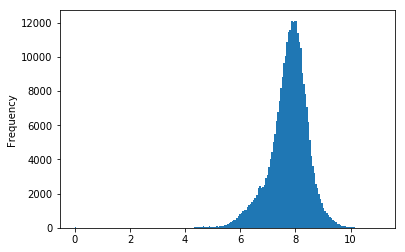

In [18]:
np.log(herald_data.article.str.len()).plot(kind = 'hist', bins = 200)

In [19]:
herald_data = herald_data[herald_data.article.str.len() > np.exp(5)]

Now there are still some html-esque characters in the data. We will find them, and replace them.

In [20]:
# Find all of the html-text
set(re.findall('&[A-z0-9]+;', ' '.join(herald_data.article.values)))

{'&amp;', '&gt;', '&lt;'}

In [21]:
def replace_html_text(s):
    '''
    Replace any cases of weird html strings
    '''
    return (s.replace("&amp;", "&")
             .replace('&gt;', '>')
             .replace('&lt;', '<'))

In [22]:
# Fix html text in articles
herald_data['article'] = herald_data['article'].apply(replace_html_text)

We can also fix all of the paragraphs to remove whitespace, and standardise the number of lines between paragraphs.

In [23]:
def fix_paragraphs(s):
    '''
    Fix any paragraphs in s
    '''
    paragraphs = []
    for par in s.split("\n"):
        par = par.strip()
        if len(par) == 0:
            continue
        paragraphs.append(par)
    return "\n\n".join(paragraphs)

In [24]:
herald_data['article'] = herald_data['article'].apply(fix_paragraphs)

In [25]:
article = herald_data.sample(1).article.values[0]
print(article)

The best thing about talking to New Zealand's Casey Robertson is her straight talking no-nonsense assessment of how her team are shaping up for a fourth World Cup title in a row, scrumqueens.com writes.

Robertson herself is looking at her third World Cup title but the previous two victories came when she was lining out in the front row for New Zealand - and she's much happier now in her favoured positons in the backrow.

"I think it's fair to say I disliked propping. Back in 2002 the coaches were looking for mobile props so I went in there to get in the squad and stayed there for five years and two World Cups which we won.

It wasn't easy, I wasn't playing there at all at any other level and after the last World Cup in 2006 I decided to call a halt to it.

"I had slipped a disk in my neck and was experiencing really bad headaches. I was playing club and for Canterbury at flanker and 8 which I loved and I decided to just myself available again as a backrow player for New Zealand."

It 

In [26]:
if not os.path.exists('../data/articles.corpus') or OVERWRITE:
    with open('../data/articles.corpus', 'w') as corpus_file:
        for i, row in herald_data.iterrows():
            corpus_file.write('\n'.join([row['headline'], row['article']]) + "\n\n")

In [27]:
if not os.path.exists("../data/herald_data.csv") or OVERWRITE:
    herald_data.to_csv("../data/herald_data.csv", index = False)

In [28]:
herald_data = herald_data.reindex()

In [29]:
herald_data.reset_index(drop = True, inplace = True)

In [30]:
herald_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304422 entries, 0 to 304421
Data columns (total 7 columns):
byline             304422 non-null object
date               304422 non-null datetime64[ns]
headline           304422 non-null object
paragraphs         304422 non-null object
syndicator_name    304422 non-null object
url                304422 non-null object
article            304422 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 16.3+ MB
